# Cart Pendulum balancing using LQR
This example shows how to use a Linear–quadratic regulator to balance the cart pendulum system

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

LQR is a model based control approach which means we need to know the model of the system in order to use it. the model of the cart pendulum system is given as follows:
$$
    \underbrace{
    \begin{bmatrix}
        1 & 0 & 0 & 0\\
        0 & 1 & 0 & 0\\
        0 & 0 & m_{c} + m_{p} & l m_{p} \cos (\theta)\\
        0 & 0 & \cos (\theta) & l
    \end{bmatrix}
    }_{\boldsymbol{M}}
    \underbrace{
    \begin{bmatrix}
        \dot{x}\\
        \dot{\theta}\\
        \ddot{x}\\
        \ddot{\theta}
    \end{bmatrix}
    }_{\boldsymbol{x}}
    =
    \underbrace{
    \begin{bmatrix}
        \dot{x}\\
        \dot{\theta}\\
        l m_{p} \dot{\theta}^{2} \sin (\theta) + u\\
        g \sin (\theta)
    \end{bmatrix}
    }_{\boldsymbol{F}}
$$

In order to make this more general we will use sympy to do the calculations symbolically

In [3]:
import sympy as sp
sp.init_printing()

# Create the symbolic variabels that we will use
m_c, m_p, l, theta, x, theta_dot, x_dot, u, g = sp.symbols('m_c m_p l theta x theta_dot x_dot u g')

# Compute mass and forcing matrix as given above
mass_matrix = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, m_c + m_p, m_p*l*sp.cos(theta)],[0, 0, sp.cos(theta), l]])
forcing_matrix = sp.Matrix([[x_dot], [theta_dot], [m_p*l*theta_dot*theta_dot*sp.sin(theta) + u], [g*sp.sin(theta)]])

We now wish to linearize the system about the equilibrim $\boldsymbol{x} = [\dot{x}, \dot{\theta}, \ddot{x}, \ddot{\theta}]^{\top} = [0, 0, 0, 0]^{\top}$. To do this we first need to get the system on the form:

$$
    \dot{\boldsymbol{x}} = f(\boldsymbol{x}, \boldsymbol{u}) = \boldsymbol{M}^{-1}\boldsymbol{F}
$$

To linearize the system we then compute the matrix $\boldsymbol{A}$ and $\boldsymbol{B}$ according to: 

$$
\boldsymbol{A} 
=
\frac{\partial f}{\partial \boldsymbol{x}}  \bigg|_{\boldsymbol{x} = 0}
=
\begin{bmatrix}
    \frac{\partial f_1}{\partial x_1}  & \cdots & \frac{\partial f_1}{\partial x_n}  \\
    \vdots          &        & \vdots          \\
    \frac{\partial f_n}{\partial x_1}  & \cdots & \frac{\partial f_n}{\partial x_n} 
\end{bmatrix}\Bigg|_{\boldsymbol{x} = 0}
$$

$$
\boldsymbol{B} 
=
\frac{\partial f}{\partial \boldsymbol{x}}  \bigg|_{\boldsymbol{x} = 0}
=
\begin{bmatrix}
    \frac{\partial f_1}{\partial u} \\
    \vdots \\
    \frac{\partial f_n}{\partial u}
\end{bmatrix}\Bigg|_{\boldsymbol{x} = 0}
$$


In [4]:
# find f(x) as specified above
f = mass_matrix.inv()@forcing_matrix

# Compute the jacobain of the system
J = sp.Matrix([sp.diff(f, x).T, sp.diff(f, theta).T, sp.diff(f, x_dot).T, sp.diff(f, theta_dot).T]).T

# Compute A and B
A = sp.simplify(J.subs({x: 0, theta: 0 , x_dot : 0, theta_dot : 0}))
B = sp.simplify(sp.diff(f, u).subs({x: 0, theta: 0 , x_dot : 0, theta_dot : 0}))

A, B

⎛⎡0       0        1  0⎤, ⎡  0  ⎤⎞
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢0       0        0  1⎥  ⎢  0  ⎥⎟
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢      -g⋅mₚ          ⎥  ⎢  1  ⎥⎟
⎜⎢0     ──────     0  0⎥  ⎢ ─── ⎥⎟
⎜⎢       m_c           ⎥  ⎢ m_c ⎥⎟
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢   g⋅(m_c + mₚ)      ⎥  ⎢ -1  ⎥⎟
⎜⎢0  ────────────  0  0⎥  ⎢─────⎥⎟
⎝⎣      l⋅m_c          ⎦  ⎣l⋅m_c⎦⎠

As a sidenote, computing the eigenvalues of the system gives:


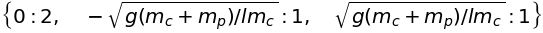

In [5]:
A.eigenvals()

Where we have a pole with positive real part, from lyapunovs indirect method we can conclude that the origin is an unstable equilibrium point. 

## Infinite-horizon, continuous-time LQR
The Infinite-horizon, continuous-time LQR givena a linerar system on the form:
$$
\dot{x} = Ax + B u
$$
can be written as minimizing the quadratic cost function:
$$
J = \int_{0}^\infty \left( x^T Q x + u^T R u + 2 x^T N u \right) dt
$$
We wish to find the feedback control law that minimizes the value of the cost. The control law is given as:
$$
u = -Kx
$$
This can be found by solving the continuouse time algebraic Ricatti equation (CARE):
$$
A^T P + P A - (P B + N) R^{-1} (B^T P + N^T) + Q = 0
$$
where
$$
K = R^{-1} (B^T P + N^T)
$$


## Infinite-horizon, discrete-time LQR
For a discrete-time linear system described by:
$$
x_{k+1} = A x_k + B u_k
$$
we wish to minimize the cost:
$$
J = \sum\limits_{k=0}^{\infty} \left( x_k^T Q x_k + u_k^T R u_k + 2 x_k^T N u_k \right)
$$
We wish to find the feedback control law that minimizes the value of the cost. The control law is given as:
$$
u = -Kx
$$
This can be found by solving the discrete time algebraic Ricatti equation (DARE):
$$
P = A^T P A - (A^T P B + N) \left( R + B^T P B \right)^{-1} (B^T P A + N^T) + Q 
$$
where: 
$$
K = (R + B^T P B)^{-1} (B^T P A + N^T) 
$$

In [6]:
import numpy as np
import scipy.linalg
 
def lqr(A ,B, Q, R, N = None):
    """Solve the continuous time lqr controller.
     
    dx/dt = A x + B u
     
    cost = integral x.T*Q*x + u.T*R*u + 2x.T*N*u
    """
 
    # Solve CARE 
    P = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R, s = N))
     
    #compute the LQR gain
    if type(N) == type(None):
        K = np.matrix(scipy.linalg.inv(R)*(B.T*P))
    else:
        K = np.matrix(scipy.linalg.inv(R)*(B.T*P + N.T))
    
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
     
    return K, P, eigVals
 
def dlqr(A, B, Q, R, N = None):
    """Solve the discrete time lqr controller.
     
     
    x[k+1] = A x[k] + B u[k]
     
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k] + 2x[k].T*N*u[k]
    """
    
    # Solve DARE
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R, s = N))
     
    #compute the LQR gain
    if type(N) == type(None):
        K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    else:
        K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A + N.T))
     
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
     
    return K, P, eigVals

## Findig the LQR gain
Using a cart mass $m_c = 1$, pendulum mass: $m_p = 0.1$, pendulum length: $l=1$, gravity $g = 9.81$ we compute the feedback gain, and inspect the eigenvalues of $A - BK$ to make shure the system will be stable.
 - Stability for continuouse system: all eigenvalues $\lambda_i$ have strictly negative real part: $Re(\lambda_i) < 0 \quad \forall i$
 - Stability for discrete system: all eigenvalues $\lambda_i$ lie within the unit circle: $|\lambda_i| < 1 \quad \forall i$

In [7]:
import scipy.signal
parameters = {m_c: env.m_c, m_p: env.m_p, l: env.l, g: env.g}

# Weight matrix Q and R
Q = np.matrix([[10, 0, 0, 0], [0, 5, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
R = np.matrix([[1]])

# Evaluate the numerical value of the continuouse A and B matrices
A_c = np.matrix(A.subs(parameters)).astype(np.float64)
B_c = np.matrix(B.subs(parameters)).astype(np.float64)

# Compute the discrete A and B matrices
A_d, B_d, _, _, _ = scipy.signal.cont2discrete((A_c, B_c, _, _), dt=env.step_size)


# Compute continuouse LQR
K_c, P_c, eig_c = lqr(A_c, B_c, Q, R)

# Compute discrete LQR
K_d, P_d, eig_d = dlqr(A_d, B_d, Q, R)

print("Re(eig_c):", eig_c.real)
print("Re(eig_c) < 0: ", eig_c.real < 0)
print()
print("abs(eig_d):", np.abs(eig_d))
print("abs(eig_d) < 1 :", np.abs(eig_d) < 1)

Re(eig_c): [-3.71660516 -2.97254672 -1.27952828 -1.27952828]
Re(eig_c) < 0:  [ True  True  True  True]

abs(eig_d): [ 0.97473486  0.97473486  0.92836301  0.94228314]
abs(eig_d) < 1 : [ True  True  True  True]


## Simulating results
The code below will render the cart pnedulum, you may get the error that ffmpg is not installed, for anaconda users this can be done by 
```bash
conda install -c conda-forge ffmpeg
```

In [8]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 1000
X = np.zeros((len(env.x), n_steps))
theta = (2*np.random.random() - 1)*0.4
state = env.init([0, theta, 0, 0])
for step in range(n_steps):
    X[:, step] = env.x
    state = env.step(-K_d@env.x)

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[0,i] - 0.2, -0.1]), 
                     line.set_data([X[0,i], X[0,i] + np.sin(X[1, i])],[0, np.cos(X[1, i])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)
HTML(anim.to_html5_video())

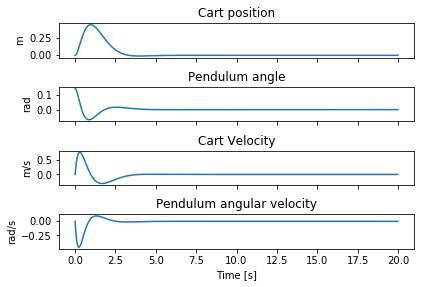

In [9]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(4, sharex=True)
for i in range(4):
    axarr[i].plot(t, X.T[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()